In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

pd.set_option('display.max_columns', 500)
%matplotlib inline

!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install plotly-geo

import plotly.figure_factory as ff

### Does patient race/gender predict receiving pain meds?

In [2]:
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
dxs = pd.read_csv('eicu-collaborative-research-database-2.0/diagnosis.csv.gz')
tm = pd.read_csv('eicu-collaborative-research-database-2.0/treatment.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')

In [3]:
tm['painmeds'] = tm['treatmentstring'].str.contains('analgesics', case = False)
tm = tm[tm.painmeds == True]

tm.drop_duplicates(subset='patientunitstayid', inplace=True)
tm.drop(['treatmentid','treatmentoffset', 'activeupondischarge'], axis=1, inplace=True)

In [4]:
tm['treatmentstring'].value_counts()

neurologic|pain / agitation / altered mentation|analgesics                                        7582
neurologic|pain / agitation / altered mentation|analgesics|narcotic analgesic                     6149
surgery|analgesics /sedatives/ nmbs|analgesics                                                    3666
pulmonary|medications|analgesics                                                                  2582
neurologic|pain / agitation / altered mentation|analgesics|bolus parenteral analgesics            2376
                                                                                                  ... 
neurologic|pain / agitation / altered mentation|analgesics|non-narcotic analgesic|indomethacin       1
gastrointestinal|medications|analgesics|transdermal analgesics                                       1
cardiovascular|myocardial ischemia / infarction|analgesics|neuraxial analgesics                      1
surgery|analgesics /sedatives/ nmbs|sedative agent|haloperidol           

In [5]:
tm.head()

,patientunitstayid,treatmentstring,painmeds
76,242070,neurologic|pain / agitation / altered mentatio...,True
123,242083,neurologic|pain / agitation / altered mentatio...,True
176,242154,neurologic|pain / agitation / altered mentatio...,True
255,242319,neurologic|pain / agitation / altered mentatio...,True
342,242380,neurologic|pain / agitation / altered mentatio...,True


In [6]:
# create dictionary of all patient IDs that received pain meds & their treatment
pm_dict = dict(zip(tm.patientunitstayid, tm.painmeds))
tm_dict = dict(zip(tm.patientunitstayid, tm.treatmentstring))

# mapping hospital region to id
region = dict(zip(hos.hospitalid, hos.region))

In [7]:
def pain_val (x, dic):
    if x in dic:
        return True
    else:
        return False
    
def get_tm (x, dic):
    if x in dic:
        return dic[x]
    else:
        return "No pain medications"
    
def get_region (x, dic):
    if x in dic:
        return dic[x]
    else:
        return np.nan

In [8]:
pts['pain_meds'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, pm_dict))
pts['tm_string'] = pts['patientunitstayid'].apply(lambda x: get_tm(x, tm_dict))

pts['hospitalregion'] = pts['hospitalid'].apply(lambda x: get_region(x, region))

pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,pain_meds,tm_string,hospitalregion
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,False,No pain medications,Midwest
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,No pain medications,Midwest
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,No pain medications,Midwest
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,False,No pain medications,Midwest
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,False,No pain medications,Midwest


In [9]:
pts_sub = pts[['gender','ethnicity', 'pain_meds', 'tm_string']]
pts_sub.head()

,gender,ethnicity,pain_meds,tm_string
0,Female,Caucasian,False,No pain medications
1,Female,Caucasian,False,No pain medications
2,Female,Caucasian,False,No pain medications
3,Male,Caucasian,False,No pain medications
4,Male,Caucasian,False,No pain medications


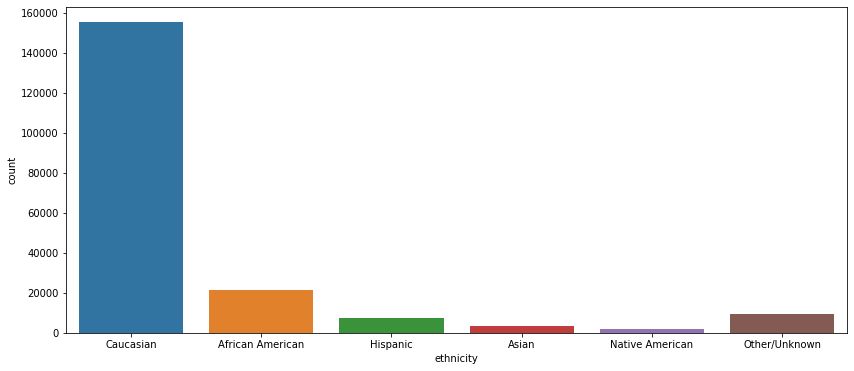

In [10]:
plt.figure(figsize=(14, 6))
sns.countplot(x='ethnicity',data=pts_sub)

In [11]:
pts_sub['ethnicity'].value_counts()

Caucasian           155273
African American     21303
Other/Unknown         9523
Hispanic              7462
Asian                 3270
Native American       1700
Name: ethnicity, dtype: int64

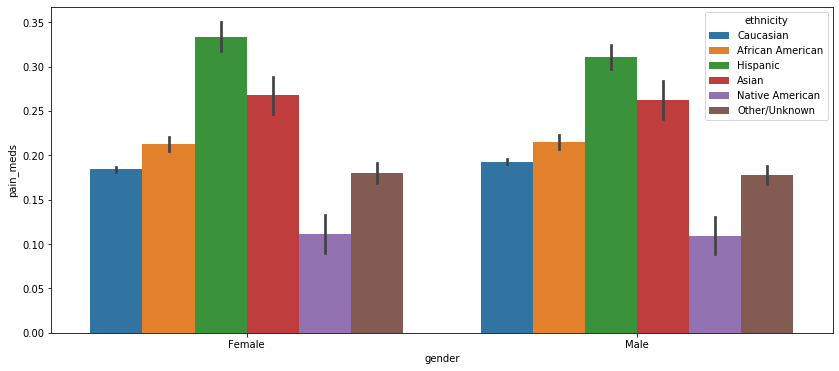

In [12]:
plt.figure(figsize=(14, 6))
sns.barplot(x='gender',y='pain_meds',hue='ethnicity',data=pts_sub, estimator=np.mean)

Distribution between gender looks the same, but but ethnicity is not. Chi Squared Test for independence (p < 0.01).

In [13]:
ct_eth = pd.crosstab(pts_sub.pain_meds, pts_sub.ethnicity, margins= True)
ct_eth

ethnicity,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown,All
pain_meds,,,,,,,
False,16754,2404,125960,5064,1513,7818,159513
True,4549,866,29313,2398,187,1705,39018
All,21303,3270,155273,7462,1700,9523,198531


In [14]:
fobs = [16754, 2404, 125960, 5064, 1513, 7818]
ftots = [21303, 3270, 155273, 7462, 1700, 9523]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

Power_divergenceResult(statistic=202.44295590235217, pvalue=8.526351751144247e-42)

 - **Therefore, ethnicity and receiving pain medication are not independent.**

In [15]:
ct_gen = pd.crosstab(pts_sub.pain_meds, pts_sub.gender, margins= True)
ct_gen

gender,Female,Male,All
pain_meds,,,
False,74431,86787,161218
True,17872,21592,39464
All,92303,108379,200682


In [16]:
fobs = [74431, 86787]
ftots = [92303, 108379]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

Power_divergenceResult(statistic=1.9484240573566582, pvalue=0.1627567748149568)

- Therefore, gender and receiving pain medication is independent.
___

In [17]:
pts_sub.head()

,gender,ethnicity,pain_meds,tm_string
0,Female,Caucasian,False,No pain medications
1,Female,Caucasian,False,No pain medications
2,Female,Caucasian,False,No pain medications
3,Male,Caucasian,False,No pain medications
4,Male,Caucasian,False,No pain medications


In [18]:
pts_log = pd.get_dummies(pts_sub,columns = ['gender', 'ethnicity'], drop_first = False)
pts_log = pts_log.drop(columns=['tm_string'])
pts_log.head()

,pain_meds,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
0,False,1,0,0,0,1,0,0,0
1,False,1,0,0,0,1,0,0,0
2,False,1,0,0,0,1,0,0,0
3,False,0,1,0,0,1,0,0,0
4,False,0,1,0,0,1,0,0,0


In [19]:
X = pts_log.drop(columns='pain_meds')
y = pts_log.pain_meds

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['pain_meds'])

# Check the numbers of our data
print("Original length of data:", len(X_train))
print("Number of no subscription (no pain meds) in data:", len(y_train)-sum(y_train))
print("Number of subscription (pain meds) in data:", sum(y_train))
print("Proportion of no subscription data in oversampled data is:",(len(y_train)-sum(y_train))/len(X_train))
print("Proportion of subscription data in oversampled data is:",sum(y_train)/len(X_train))
print("-----")
print("Length of oversampled data is:",len(os_data_X))
print("Number of no subscription (no pain meds) in oversampled data:",len(os_data_y[os_data_y['pain_meds']==0]))
print("Number of subscription (pain meds) in data:",len(os_data_y[os_data_y['pain_meds']==1]))
print("Proportion of no subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==1])/len(os_data_X))

Original length of data: 140571
Number of no subscription (no pain meds) in data: 112890
Number of subscription (pain meds) in data: 27681
Proportion of no subscription data in oversampled data is: 0.8030817167125509
Proportion of subscription data in oversampled data is: 0.19691828328744904
-----
Length of oversampled data is: 225780
Number of no subscription (no pain meds) in oversampled data: 112890
Number of subscription (pain meds) in data: 112890
Proportion of no subscription data in oversampled data is: 0.5
Proportion of subscription data in oversampled data is: 0.5


In [21]:
import statsmodels.api as sm

logit_model=sm.Logit(os_data_y,os_data_X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.689496
         Iterations 4
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.005      
Dependent Variable:    pain_meds           AIC:                 311364.7062
Date:                  2020-07-16 05:11    BIC:                 311447.3248
No. Observations:      225780              Log-Likelihood:      -1.5567e+05
Df Model:              7                   LL-Null:             -1.5650e+05
Df Residuals:          225772              LLR p-value:         0.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        4.0000                                              
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
gender_Female    

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [23]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.72


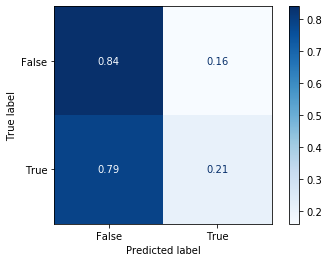

In [24]:
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.84      0.83     48451
        True       0.24      0.21      0.23     11794

    accuracy                           0.72     60245
   macro avg       0.53      0.53      0.53     60245
weighted avg       0.70      0.72      0.71     60245



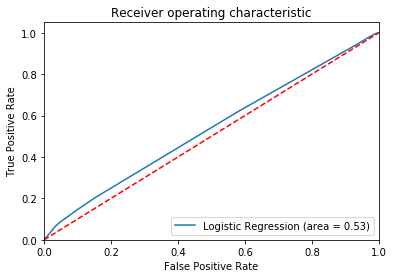

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Now adding all variables to the logistic regression:

In [27]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,pain_meds,tm_string,hospitalregion
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,False,No pain medications,Midwest
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,No pain medications,Midwest
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,No pain medications,Midwest
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,False,No pain medications,Midwest
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,False,No pain medications,Midwest


In [28]:
pts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200816 entries, 0 to 200858
Data columns (total 32 columns):
patientunitstayid            200816 non-null int64
patienthealthsystemstayid    200816 non-null int64
gender                       200682 non-null object
age                          200721 non-null object
ethnicity                    198531 non-null object
hospitalid                   200816 non-null int64
wardid                       200816 non-null int64
apacheadmissiondx            177826 non-null object
admissionheight              196616 non-null float64
hospitaladmittime24          200816 non-null object
hospitaladmitoffset          200816 non-null int64
hospitaladmitsource          151359 non-null object
hospitaldischargeyear        200816 non-null int64
hospitaldischargetime24      200816 non-null object
hospitaldischargeoffset      200816 non-null int64
hospitaldischargelocation    198783 non-null object
hospitaldischargestatus      199065 non-null object
unittype   

In [29]:
pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)
pts['age'].fillna(value = 0, inplace = True)

In [30]:
def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)

pts['age'] = pts['age'].apply(lambda x: age(x))

In [31]:
def get_hour (x):
    return x[0:2]

pts['hospitaladmittime24'] = pts['hospitaladmittime24'].apply(lambda x: get_hour(x))
pts['hospitaldischargetime24'] = pts['hospitaldischargetime24'].apply(lambda x: get_hour(x))
pts['unitadmittime24'] = pts['unitadmittime24'].apply(lambda x: get_hour(x))
pts['unitdischargetime24'] = pts['unitdischargetime24'].apply(lambda x: get_hour(x))

In [32]:
cat_cols = ['gender', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'hospitaladmitsource', 
            'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmitsource', 'unitvisitnumber',
           'unitstaytype', 'unitdischargelocation', 'unitdischargestatus', 'hospitalregion']

pts_log = pd.get_dummies(pts, columns = cat_cols, drop_first = False)

In [33]:
pts_log.head()

,patientunitstayid,patienthealthsystemstayid,age,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,unitadmittime24,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,uniquepid,pain_meds,tm_string,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospitalid_56,hospitalid_58,hospitalid_59,hospitalid_60,hospitalid_61,hospitalid_63,hospitalid_66,hospitalid_67,hospitalid_68,hospitalid_69,hospitalid_71,hospitalid_73,hospitalid_79,hospitalid_83,hospitalid_84,hospitalid_85,hospitalid_86,hospitalid_90,hospitalid_91,hospitalid_92,hospitalid_93,hospitalid_94,hospitalid_95,hospitalid_96,hospitalid_102,hospitalid_108,hospitalid_110,hospitalid_112,hospitalid_115,hospitalid_120,hospitalid_122,hospitalid_123,hospitalid_125,hospitalid_131,hospitalid_133,hospitalid_135,hospitalid_136,hospitalid_138,hospitalid_140,hospitalid_141,hospitalid_142,hospitalid_143,hospitalid_144,hospitalid_146,hospitalid_148,hospitalid_151,hospitalid_152,hospitalid_154,hospitalid_155,hospitalid_156,hospitalid_157,hospitalid_158,hospitalid_164,hospitalid_165,hospitalid_167,hospitalid_171,hospitalid_174,hospitalid_175,hospitalid_176,hospitalid_179,hospitalid_180,hospitalid_181,hospitalid_182,hospitalid_183,hospitalid_184,hospitalid_188,hospitalid_194,hospitalid_195,hospitalid_196,hospitalid_197,hospitalid_198,hospitalid_199,hospitalid_200,hospitalid_201,hospitalid_202,hospitalid_203,hospitalid_204,hospitalid_205,hospitalid_206,hospitalid_207,hospitalid_208,hospitalid_209,hospitalid_210,hospitalid_212,hospitalid_215,hospitalid_217,hospitalid_220,hospitalid_224,hospitalid_226,hospitalid_227,hospitalid_243,hospitalid_244,hospitalid_245,hospitalid_246,hospitalid_248,hospitalid_249,hospitalid_250,hospitalid_251,hospitalid_252,hospitalid_253,hospitalid_254,hospitalid_256,hospitalid_258,hospitalid_259,hospitalid_262,hospitalid_263,hospitalid_264,hospitalid_265,hospitalid_266,hospitalid_267,hospitalid_268,hospitalid_269,hospitalid_271,hospitalid_272,hospitalid_273,hospitalid_275,hospitalid_277,hospitalid_279,hospitalid_280,hospitalid_281,hospitalid_282,hospitalid_283,hospitalid_300,hospitalid_301,hospitalid_303,hospitalid_307,hospitalid_310,hospitalid_312,hospitalid_318,hospitalid_323,hospitalid_328,hospitalid_331,hospitalid_336,hospitalid_337,hospitalid_338,hospitalid_342,hospitalid_345,hospitalid_350,hospitalid_351,hospitalid_352,hospitalid_353,hospitalid_355,hospitalid_356,hospitalid_357,hospitalid_358,hospitalid_360,hospitalid_361,hospitalid_363,hospitalid_364,hospitalid_365,hospitalid_381,hospitalid_382,hospitalid_383,hospitalid_384,hospitalid_385,hospitalid_386,hospitalid_387,hospitalid_388,hospitalid_389,hospitalid_390,hospitalid_391,hospitalid_392,hospitalid_393,hospitalid_394,hospitalid_396,hospitalid_397,hospitalid_398,hospitalid_399,hospitalid_400,hospitalid_401,hospitalid_402,hospitalid_403,hospitalid_404,hospitalid_405,hospitalid_407,hospitalid_408,hospitalid_409,hospitalid_411,hospitalid_412,hospitalid_413,hospitalid_414,hospitalid_416,hospitalid_417,hospitalid_419,hospitalid_420,hospitalid_421,hospitalid_422,hospitalid_423,hospitalid_424,hospitalid_425,hospitalid_428,hospitalid_429,hospitalid_433,hospitalid_434,hospitalid_435,hospitalid_436,hospitalid_437,hospitalid_438,hospitalid_439,hospitalid_440,hospitalid_443,hospitalid_444,hospitalid_445,hospitalid_447,hospitalid_449,hospitalid_452,hospitalid_458,hospitalid_459,wardid_82,wardid_83,wardid_85,wardid_87,wardid_89,wardid_90,wardid_91,wardid_92,wardid_93,wardid_95,wardid_97,wardid_98,wardid_99,wardid_100,wardid_102,wardid_103,wardid_108,...,"apacheadmissiondx_Leukemia, acute lymphocytic","apacheadmissiondx_Leukemia, acute myelocytic","apacheadmissiondx_Leukemia, chronic lymphocytic","apacheadmissiondx_Leukemia, chronic myelocytic","apacheadmissiondx_Leukemia, other",apacheadmissiondx_Liver transplant,"apacheadm

In [34]:
X = pts_log.drop(columns=['pain_meds', 'tm_string', 'admissionweight', 'patientunitstayid', 'patienthealthsystemstayid', 
                         'uniquepid', 'dischargeweight', 'admissionheight'])
y = pts_log.pain_meds

In [35]:
X.head()

,age,hospitaladmittime24,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,unitadmittime24,unitdischargetime24,unitdischargeoffset,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospitalid_56,hospitalid_58,hospitalid_59,hospitalid_60,hospitalid_61,hospitalid_63,hospitalid_66,hospitalid_67,hospitalid_68,hospitalid_69,hospitalid_71,hospitalid_73,hospitalid_79,hospitalid_83,hospitalid_84,hospitalid_85,hospitalid_86,hospitalid_90,hospitalid_91,hospitalid_92,hospitalid_93,hospitalid_94,hospitalid_95,hospitalid_96,hospitalid_102,hospitalid_108,hospitalid_110,hospitalid_112,hospitalid_115,hospitalid_120,hospitalid_122,hospitalid_123,hospitalid_125,hospitalid_131,hospitalid_133,hospitalid_135,hospitalid_136,hospitalid_138,hospitalid_140,hospitalid_141,hospitalid_142,hospitalid_143,hospitalid_144,hospitalid_146,hospitalid_148,hospitalid_151,hospitalid_152,hospitalid_154,hospitalid_155,hospitalid_156,hospitalid_157,hospitalid_158,hospitalid_164,hospitalid_165,hospitalid_167,hospitalid_171,hospitalid_174,hospitalid_175,hospitalid_176,hospitalid_179,hospitalid_180,hospitalid_181,hospitalid_182,hospitalid_183,hospitalid_184,hospitalid_188,hospitalid_194,hospitalid_195,hospitalid_196,hospitalid_197,hospitalid_198,hospitalid_199,hospitalid_200,hospitalid_201,hospitalid_202,hospitalid_203,hospitalid_204,hospitalid_205,hospitalid_206,hospitalid_207,hospitalid_208,hospitalid_209,hospitalid_210,hospitalid_212,hospitalid_215,hospitalid_217,hospitalid_220,hospitalid_224,hospitalid_226,hospitalid_227,hospitalid_243,hospitalid_244,hospitalid_245,hospitalid_246,hospitalid_248,hospitalid_249,hospitalid_250,hospitalid_251,hospitalid_252,hospitalid_253,hospitalid_254,hospitalid_256,hospitalid_258,hospitalid_259,hospitalid_262,hospitalid_263,hospitalid_264,hospitalid_265,hospitalid_266,hospitalid_267,hospitalid_268,hospitalid_269,hospitalid_271,hospitalid_272,hospitalid_273,hospitalid_275,hospitalid_277,hospitalid_279,hospitalid_280,hospitalid_281,hospitalid_282,hospitalid_283,hospitalid_300,hospitalid_301,hospitalid_303,hospitalid_307,hospitalid_310,hospitalid_312,hospitalid_318,hospitalid_323,hospitalid_328,hospitalid_331,hospitalid_336,hospitalid_337,hospitalid_338,hospitalid_342,hospitalid_345,hospitalid_350,hospitalid_351,hospitalid_352,hospitalid_353,hospitalid_355,hospitalid_356,hospitalid_357,hospitalid_358,hospitalid_360,hospitalid_361,hospitalid_363,hospitalid_364,hospitalid_365,hospitalid_381,hospitalid_382,hospitalid_383,hospitalid_384,hospitalid_385,hospitalid_386,hospitalid_387,hospitalid_388,hospitalid_389,hospitalid_390,hospitalid_391,hospitalid_392,hospitalid_393,hospitalid_394,hospitalid_396,hospitalid_397,hospitalid_398,hospitalid_399,hospitalid_400,hospitalid_401,hospitalid_402,hospitalid_403,hospitalid_404,hospitalid_405,hospitalid_407,hospitalid_408,hospitalid_409,hospitalid_411,hospitalid_412,hospitalid_413,hospitalid_414,hospitalid_416,hospitalid_417,hospitalid_419,hospitalid_420,hospitalid_421,hospitalid_422,hospitalid_423,hospitalid_424,hospitalid_425,hospitalid_428,hospitalid_429,hospitalid_433,hospitalid_434,hospitalid_435,hospitalid_436,hospitalid_437,hospitalid_438,hospitalid_439,hospitalid_440,hospitalid_443,hospitalid_444,hospitalid_445,hospitalid_447,hospitalid_449,hospitalid_452,hospitalid_458,hospitalid_459,wardid_82,wardid_83,wardid_85,wardid_87,wardid_89,wardid_90,wardid_91,wardid_92,wardid_93,wardid_95,wardid_97,wardid_98,wardid_99,wardid_100,wardid_102,wardid_103,wardid_108,wardid_109,wardid_113,wardid_114,wardid_120,wardid_123,wardid_125,wardid_126,wardid_133,...,"apacheadmissiondx_Leukemia, acute lymphocytic","apacheadmissiondx_Leukemia, acute myelocytic","apacheadmissiondx_Leukemia, chronic lymphocytic","apacheadmissiondx_Leukemia, chronic myelocytic","apacheadmissiondx_Leukemia, other",apacheadmissiondx_Liver transplant,"apacheadmissiondx_Lung transplant, bilatera

In [36]:
X.columns[X.isnull().any()]

Index([], dtype='object')

In [37]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['pain_meds'])

# Check the numbers of our data
print("Original length of data:", len(X_train))
print("Number of no subscription (no pain meds) in data:", len(y_train)-sum(y_train))
print("Number of subscription (pain meds) in data:", sum(y_train))
print("Proportion of no subscription data in oversampled data is:",(len(y_train)-sum(y_train))/len(X_train))
print("Proportion of subscription data in oversampled data is:",sum(y_train)/len(X_train))
print("-----")
print("Length of oversampled data is:",len(os_data_X))
print("Number of no subscription (no pain meds) in oversampled data:",len(os_data_y[os_data_y['pain_meds']==0]))
print("Number of subscription (pain meds) in data:",len(os_data_y[os_data_y['pain_meds']==1]))
print("Proportion of no subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==1])/len(os_data_X))

Original length of data: 140571
Number of no subscription (no pain meds) in data: 112890
Number of subscription (pain meds) in data: 27681
Proportion of no subscription data in oversampled data is: 0.8030817167125509
Proportion of subscription data in oversampled data is: 0.19691828328744904
-----
Length of oversampled data is: 225780
Number of no subscription (no pain meds) in oversampled data: 112890
Number of subscription (pain meds) in data: 112890
Proportion of no subscription data in oversampled data is: 0.5
Proportion of subscription data in oversampled data is: 0.5


In [38]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [39]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


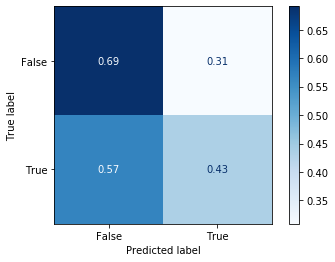

In [40]:
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.69      0.76     48451
        True       0.25      0.43      0.32     11794

    accuracy                           0.64     60245
   macro avg       0.54      0.56      0.54     60245
weighted avg       0.72      0.64      0.67     60245



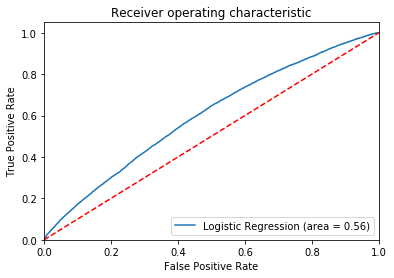

In [42]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Notes:
 - This is still just a first pass and could potentially be improved by imputing some of missing values instad of removing them completely (notably height and weight).
 - Adding several other features including hospital region didnt really make a difference.
 ___

In [43]:
nsc = pd.read_csv('eicu-collaborative-research-database-2.0/nurseCharting.csv.gz')

In [44]:
nsc.drop(['nursingchartid','nursingchartoffset', 'nursingchartentryoffset', 
          'nursingchartcelltypecat', 'nursingchartcelltypevallabel'], axis=1, inplace=True)
nsc = nsc[nsc['nursingchartcelltypevalname'] == 'Pain Score']

In [45]:
nsc.patientunitstayid.value_counts()

199499     3389
3172552    1315
3114528    1305
3074177    1265
3146941    1252
           ... 
1478822       1
1067133       1
1072421       1
1070816       1
156618        1
Name: patientunitstayid, Length: 76400, dtype: int64

In [46]:
nsc.head()

,patientunitstayid,nursingchartcelltypevalname,nursingchartvalue
7,141924,Pain Score,2
16,141924,Pain Score,2
40,141924,Pain Score,5
71,141924,Pain Score,3
105,141924,Pain Score,3


In [47]:
nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: float(x))

In [48]:
valid = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
nsc = nsc[nsc['nursingchartvalue'].isin(valid)]

In [49]:
nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: int(x))
nsc.drop(['nursingchartcelltypevalname'], axis=1, inplace=True)

In [50]:
max_pain = nsc.groupby('patientunitstayid').max()
med_pain = nsc.groupby('patientunitstayid').median()

In [51]:
med_pain['nursingchartvalue']

patientunitstayid
141168     0.0
141178     0.0
141179     0.0
141194     0.0
141196     0.0
          ... 
3352758    8.0
3352781    1.0
3352837    1.5
3353077    4.0
3353184    4.0
Name: nursingchartvalue, Length: 76318, dtype: float64

In [52]:
def pain_val (x, arr):
    try:
        return arr['nursingchartvalue'][x]
    except:
        return np.nan

In [53]:
pts_log['max_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, max_pain))

In [54]:
pts_log.head()

,patientunitstayid,patienthealthsystemstayid,age,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,unitadmittime24,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,uniquepid,pain_meds,tm_string,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospitalid_56,hospitalid_58,hospitalid_59,hospitalid_60,hospitalid_61,hospitalid_63,hospitalid_66,hospitalid_67,hospitalid_68,hospitalid_69,hospitalid_71,hospitalid_73,hospitalid_79,hospitalid_83,hospitalid_84,hospitalid_85,hospitalid_86,hospitalid_90,hospitalid_91,hospitalid_92,hospitalid_93,hospitalid_94,hospitalid_95,hospitalid_96,hospitalid_102,hospitalid_108,hospitalid_110,hospitalid_112,hospitalid_115,hospitalid_120,hospitalid_122,hospitalid_123,hospitalid_125,hospitalid_131,hospitalid_133,hospitalid_135,hospitalid_136,hospitalid_138,hospitalid_140,hospitalid_141,hospitalid_142,hospitalid_143,hospitalid_144,hospitalid_146,hospitalid_148,hospitalid_151,hospitalid_152,hospitalid_154,hospitalid_155,hospitalid_156,hospitalid_157,hospitalid_158,hospitalid_164,hospitalid_165,hospitalid_167,hospitalid_171,hospitalid_174,hospitalid_175,hospitalid_176,hospitalid_179,hospitalid_180,hospitalid_181,hospitalid_182,hospitalid_183,hospitalid_184,hospitalid_188,hospitalid_194,hospitalid_195,hospitalid_196,hospitalid_197,hospitalid_198,hospitalid_199,hospitalid_200,hospitalid_201,hospitalid_202,hospitalid_203,hospitalid_204,hospitalid_205,hospitalid_206,hospitalid_207,hospitalid_208,hospitalid_209,hospitalid_210,hospitalid_212,hospitalid_215,hospitalid_217,hospitalid_220,hospitalid_224,hospitalid_226,hospitalid_227,hospitalid_243,hospitalid_244,hospitalid_245,hospitalid_246,hospitalid_248,hospitalid_249,hospitalid_250,hospitalid_251,hospitalid_252,hospitalid_253,hospitalid_254,hospitalid_256,hospitalid_258,hospitalid_259,hospitalid_262,hospitalid_263,hospitalid_264,hospitalid_265,hospitalid_266,hospitalid_267,hospitalid_268,hospitalid_269,hospitalid_271,hospitalid_272,hospitalid_273,hospitalid_275,hospitalid_277,hospitalid_279,hospitalid_280,hospitalid_281,hospitalid_282,hospitalid_283,hospitalid_300,hospitalid_301,hospitalid_303,hospitalid_307,hospitalid_310,hospitalid_312,hospitalid_318,hospitalid_323,hospitalid_328,hospitalid_331,hospitalid_336,hospitalid_337,hospitalid_338,hospitalid_342,hospitalid_345,hospitalid_350,hospitalid_351,hospitalid_352,hospitalid_353,hospitalid_355,hospitalid_356,hospitalid_357,hospitalid_358,hospitalid_360,hospitalid_361,hospitalid_363,hospitalid_364,hospitalid_365,hospitalid_381,hospitalid_382,hospitalid_383,hospitalid_384,hospitalid_385,hospitalid_386,hospitalid_387,hospitalid_388,hospitalid_389,hospitalid_390,hospitalid_391,hospitalid_392,hospitalid_393,hospitalid_394,hospitalid_396,hospitalid_397,hospitalid_398,hospitalid_399,hospitalid_400,hospitalid_401,hospitalid_402,hospitalid_403,hospitalid_404,hospitalid_405,hospitalid_407,hospitalid_408,hospitalid_409,hospitalid_411,hospitalid_412,hospitalid_413,hospitalid_414,hospitalid_416,hospitalid_417,hospitalid_419,hospitalid_420,hospitalid_421,hospitalid_422,hospitalid_423,hospitalid_424,hospitalid_425,hospitalid_428,hospitalid_429,hospitalid_433,hospitalid_434,hospitalid_435,hospitalid_436,hospitalid_437,hospitalid_438,hospitalid_439,hospitalid_440,hospitalid_443,hospitalid_444,hospitalid_445,hospitalid_447,hospitalid_449,hospitalid_452,hospitalid_458,hospitalid_459,wardid_82,wardid_83,wardid_85,wardid_87,wardid_89,wardid_90,wardid_91,wardid_92,wardid_93,wardid_95,wardid_97,wardid_98,wardid_99,wardid_100,wardid_102,wardid_103,wardid_108,...,"apacheadmissiondx_Leukemia, acute myelocytic","apacheadmissiondx_Leukemia, chronic lymphocytic","apacheadmissiondx_Leukemia, chronic myelocytic","apacheadmissiondx_Leukemia, other",apacheadmissiondx_Liver transplant,"apacheadmissiondx_Lung transplant, bilateral","apacheadmi

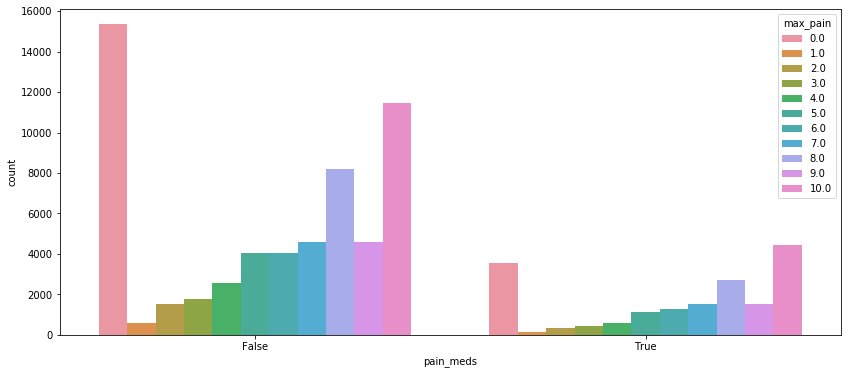

In [55]:
plt.figure(figsize=(14, 6))
sns.countplot(x='pain_meds', hue='max_pain', data=pts_log)

About 62% of the pain scores are missing so they wouldn't be a viable metric?

In [56]:
plt.figure(figsize=(14, 6))
sns.barplot(x='pain_meds',y='max_pain',hue='ethnicity',data=pts, estimator=np.mean)

ValueError: Could not interpret input 'max_pain'

<Figure size 1008x432 with 0 Axes>

In [ ]:
X = pts_log.drop(columns=['pain_meds', 'tm_string', 'admissionweight', 'patientunitstayid', 'patienthealthsystemstayid', 
                         'uniquepid'])
y = pts_log.pain_meds

In [ ]:
X.columns[X.isnull().any()]

In [ ]:
pts_drops = pts_log.dropna()

X = pts_drops.drop(columns=['pain_meds', 'tm_string', 'admissionweight', 'patientunitstayid', 'patienthealthsystemstayid', 
                         'uniquepid'])
y = pts_drops.pain_meds

In [ ]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['pain_meds'])

# Check the numbers of our data
print("Original length of data:", len(X_train))
print("Number of no subscription (no pain meds) in data:", len(y_train)-sum(y_train))
print("Number of subscription (pain meds) in data:", sum(y_train))
print("Proportion of no subscription data in oversampled data is:",(len(y_train)-sum(y_train))/len(X_train))
print("Proportion of subscription data in oversampled data is:",sum(y_train)/len(X_train))
print("-----")
print("Length of oversampled data is:",len(os_data_X))
print("Number of no subscription (no pain meds) in oversampled data:",len(os_data_y[os_data_y['pain_meds']==0]))
print("Number of subscription (pain meds) in data:",len(os_data_y[os_data_y['pain_meds']==1]))
print("Proportion of no subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==1])/len(os_data_X))

In [ ]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ROCAUC Results:
- Just gender and ethnicity : 0.50
- All variables : 0.53
- Added pain scores : 0.59